In [8]:
import numpy as np
import math as m
import rk4
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd

from tqdm.notebook import tqdm
from typing import Tuple

In [2]:
# система дифференциальных уравнений
# t - время
# x - вектор состояния системы
# c - вектор дополнительных констант
# v - вектор дополнительных переменных
# v["x_0"] = c["mu"] / (x[0]**2 + x[1]**2)**1.5
# v["x_1"] = c["f_eng"] / x[4]
# v["psi_0"] = -3 * c["mu"] * (x[7] * x[0] + x[8] * x[1]) / (x[0]**2 + x[1]**2)**2.5
# v["psi_1"] = x[7] * m.cos(v["u"]) + x[8] * m.sin(v["u"])
eqs = np.array([
    lambda t, x, c, v: x[2],                                            # dx1/dt
    lambda t, x, c, v: x[3],                                            # dx2/dt
    lambda t, x, c, v: -x[0] * v["x_0"] + m.cos(v["u"]) * v["x_1"],     # dx3/dt
    lambda t, x, c, v: -x[1] * v["x_0"] + m.sin(v["u"]) * v["x_1"],     # dx4/dt
    lambda t, x, c, v: -c["gamma"],                                     # dx5/dt
    lambda t, x, c, v: x[7] * v["x_0"] + x[0] * v["psi_0"],             # dpsi1/dt
    lambda t, x, c, v: x[8] * v["x_0"] + x[1] * v["psi_0"],             # dpsi2/dt
    lambda t, x, c, v: -x[5],                                           # dpsi3/dt
    lambda t, x, c, v: -x[6],                                           # dpsi4/dt
    lambda t, x, c, v: c["f_eng"] * v["psi_1"] / x[4]**2,               # dpsi5/dt
])

eq_u = lambda x, c, v: m.atan(x[8] / x[7])
eq_dH = lambda x, c, v: x[8] * m.cos(v["u"]) - x[7] * m.sin(v["u"])
eq_d2H = lambda x, c, v: v["psi_1"]
eq_H = lambda x, c, v: x[5]*x[2] + x[6]*x[3] - v["x_0"]*(x[7] * x[0] + x[8] * x[1]) + (c["f_eng"] / x[4])*v["psi_1"] - x[9]*c["gamma"] - 1

In [3]:
def calculation_step_state(x: np.ndarray, consts: dict) -> Tuple[bool, dict, np.ndarray]:
    vars = {}
    vars["u"] = eq_u(x, c=consts, v=vars)
    vars["x_0"] = consts["mu"] / (x[0]**2 + x[1]**2)**1.5
    vars["x_1"] = consts["f_eng"] / x[4]
    vars["psi_0"] = -3 * consts["mu"] * (x[7] * x[0] + x[8] * x[1]) / (x[0]**2 + x[1]**2)**2.5
    vars["psi_1"] = x[7] * m.cos(vars["u"]) + x[8] * m.sin(vars["u"])

    dH = eq_dH(x, c=consts, v=vars)
    d2H = eq_d2H(x, c=consts, v=vars)
    valH = eq_H(x, c=consts, v=vars)
    
    return True, vars, np.array([dH, d2H, valH])

In [11]:
consts = {"mu": 1.3271845549999999e+20, "gamma": 0.000012, "f_eng": 0.270}
step = 1000.
t_arr = np.arange(0., 86400. * 365., step)

# result matrix column = [t, x0, x1, x2, x3, x4, x5, x6, x7, x8, x9, u, dH, d2H, H]
result = np.zeros(shape=(t_arr.size, 15))
result[:, 0] = t_arr

x0 = 146095000000.
x1 = 0.
x2 = 0.
x3 = 29500.
x4 = 2900.
psi0 = 1.
psi1 = 1.
psi2 = 1.
psi3 = 1.
psi4 = 1.

x_init = np.array([x0, x1, x2, x3, x4, psi0, psi1, psi2, psi3, psi4])
is_H_valid, vars, h_arr = calculation_step_state(x_init, consts)

result[0][1:] = np.append(np.append(x_init, vars["u"]), h_arr)

for i in tqdm(np.arange(1, result[:,0].size, 1)):
    current_state = result[i-1][1:11]
    current_dif_var = result[i-1][0]
    
    next_state = rk4.rk4_step(eqs, current_state, current_dif_var, step, constants=consts, nonstdvars=vars)
    is_H_valid, vars, h_arr = calculation_step_state(current_state, consts)
    
    result[i][1:] = np.append(np.append(next_state, vars["u"]), h_arr)

  0%|          | 0/31535 [00:00<?, ?it/s]

In [12]:
df = pd.DataFrame(data=result, columns=['t', 'x1', 'x2', 'x3', 'x4', 'x5', 'psi1', 'psi2', 'psi3', 'psi4', 'psi5', 'u', 'dH', 'd2H', 'H'])
df

,t,x1,x2,x3,x4,x5,psi1,psi2,psi3,psi4,psi5,u,dH,d2H,H
0,0.0,1.460950e+11,0.000000e+00,0.000000,29500.000000,2900.000,1.000000,1.000000,1.000000e+00,1.000000e+00,1.000000e+00,0.785398,0.000000e+00,1.414214e+00,29498.993902
1,1000.0,1.460950e+11,2.950003e+07,-6.152308,29500.065206,2899.988,1.000000,1.000000,-9.990000e+02,-9.990000e+02,1.000045e+00,0.785398,0.000000e+00,1.414214e+00,29498.993902
2,2000.0,1.460950e+11,5.900013e+07,-12.304615,29500.129157,2899.976,1.000000,1.000000,-1.999000e+03,-1.999000e+03,1.000091e+00,0.785398,-1.136868e-13,-1.412799e+03,29498.993901
3,3000.0,1.460950e+11,8.850029e+07,-18.456921,29500.191852,2899.964,1.000000,1.000000,-2.999000e+03,-2.999000e+03,9.547325e-01,0.785398,0.000000e+00,-2.827013e+03,29498.993899
4,4000.0,1.460950e+11,1.180005e+08,-24.609227,29500.253292,2899.952,1.000000,1.000000,-3.999000e+03,-3.999000e+03,8.639696e-01,0.785398,0.000000e+00,-4.241226e+03,29498.993898
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31531,31531000.0,1.316001e+11,8.925764e+10,-13721.313733,24221.393134,2521.628,14.595531,9.501475,-4.765593e+07,6.965815e+07,3.277658e+07,-0.971000,0.000000e+00,-8.439951e+07,22220.368116
31532,31532000.0,1.315864e+11,8.928186e+10,-13725.597150,24218.357981,2521.616,14.593985,9.503793,-4.767052e+07,6.964864e+07,3.277299e+07,-0.970794,0.000000e+00,-8.439991e+07,22220.365756
31533,31533000.0,1.315727e+11,8.930608e+10,-13729.879911,24215.322165,2521.604,14.592439,9.506111,-4.768511e+07,6.963914e+07,3.276941e+07,-0.970588,-7.450581e-09,-8.440031e+07,22220.363396
31534,31534000.0,1.315589e+11,8.933029e+10,-13734.162018,24212.285686,2521.592,14.590893,9.508428,-4.769970e+07,6.962963e+07,3.276583e+07,-0.970382,0.000000e+00,-8.440071e+07,22220.361037


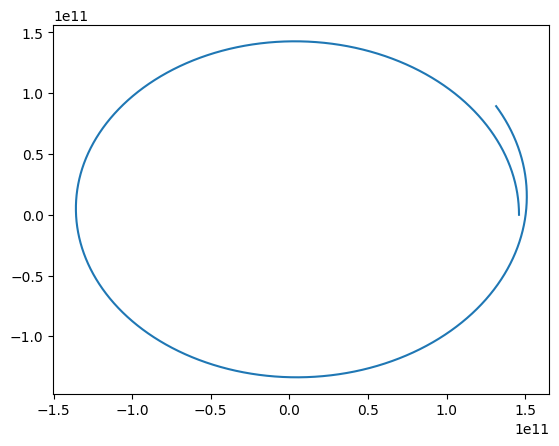

In [17]:
plt.plot(df['x1'], df['x2'])
plt.show()